<h2>Importing Libraries</h2>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Only one import
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Small
from sklearn.metrics import confusion_matrix, average_precision_score
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import random
import glob
import warnings
import time
import requests

warnings.simplefilter(action='ignore', category=FutureWarning)

<h2>Checking For GPU Availability</h2>

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


<h2>Data Preparation and Loading</h2>

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
import os
import time
import requests

class_names = ["bull-dog", "chihuahua", "german-shepherd", "golden-retriever", "husky"]
site = [
    "https://www.gettyimages.com/search/2/image-film?family=creative&phrase=bull%20dog",
    "https://www.gettyimages.com/search/2/image-film?family=creative&phrase=chihuahua",
    "https://www.gettyimages.com/search/2/image-film?family=creative&phrase=german%20shepherd",
    "https://www.gettyimages.com/search/2/image-film?family=creative&phrase=golden%20retriever",
    "https://www.gettyimages.com/search/2/image-film?family=creative&phrase=husky"
]

# Change to the directory where you want to download images
os.chdir("/home/hakiminaim/tensorflow_env/principle-of-ai/Dog-Breed/datasets")

# Set up Chrome options
chrome_options = Options()
chrome_options.add_argument("--headless")  # Ensure Chrome runs in headless mode
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Create Chrome service (do not specify executable_path since it's globally accessible)
service = Service()

# Initialize the WebDriver with the service and options
driver = webdriver.Chrome(service=service, options=chrome_options)

# Maximize the window (optional)
driver.maximize_window()

# Function to scroll to the bottom of the page to load all images
def scroll_to_bottom():
    last_height = driver.execute_script('return document.body.scrollHeight')

    while True:
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight)')
        time.sleep(5)  # Wait longer for images to load

        new_height = driver.execute_script('return document.body.scrollHeight')

        # Check if we've reached the bottom of the page
        if new_height == last_height:
            break

        last_height = new_height

    time.sleep(5)  # Extra sleep to allow final images to load

# Loop through each URL and download images
for i in range(0, 5):
    total_downloaded = 0
    page_number = 1  # Start with page 1 for each class

    while total_downloaded < 2000:  # Loop until we reach the target of 2000 images
        # Construct the URL for the current page
        current_url = f"{site[i]}&page={page_number}"

        # Open URL in the browser
        driver.get(current_url)

        # Scroll to the bottom to load images
        scroll_to_bottom()

        # Find all image tags and filter the ones with valid src URLs
        img_tags = driver.find_elements(By.TAG_NAME, 'img')
        img_urls = [img.get_attribute('src') for img in img_tags if 'media.gettyimages' in img.get_attribute('src')]

        # Download the images
        for index, url in enumerate(img_urls[:2000 - total_downloaded]):
            response = requests.get(url, stream=True)

            # Save the image to disk
            with open(f'{class_names[i]}_{total_downloaded + index + 1}.jpg', 'wb') as f:
                for chunk in response.iter_content(chunk_size=128):
                    f.write(chunk)

        total_downloaded += len(img_urls)

        print(f"Downloaded {min(len(img_urls), 2000 - total_downloaded)} images for class: {class_names[i]}")

        # Check if there is a next page
        page_number += 1

        # Wait for the next page to load and prevent excessive requests
        time.sleep(5)

    print(f"Finished downloading images for class: {class_names[i]}")

# Close the driver
driver.quit()


Downloaded 68 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 67 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 0 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 67 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 67 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 68 images for class: bull-dog
Downloaded 68 ima

In [ ]:
import os
import shutil

# List of directories where the images are stored
directories = [
    "/home/hakiminaim/tensorflow_env/principle-of-ai/datasets/bull-dog",
    "/home/hakiminaim/tensorflow_env/principle-of-ai/datasets/chihuahua",
    "/home/hakiminaim/tensorflow_env/principle-of-ai/datasets/german-shepherd",
    "/home/hakiminaim/tensorflow_env/principle-of-ai/datasets/golden-retriever",
    "/home/hakiminaim/tensorflow_env/principle-of-ai/datasets/husky"
]

# Destination directory where all images will be moved
destination_dir = "/home/hakiminaim/tensorflow_env/principle-of-ai/datasets"

# Function to rename and move images
def rename_and_move_images():
    for directory in directories:
        # Get all files in the directory
        files = os.listdir(directory)

        # Filter out only image files (optional: add extensions check if necessary)
        image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Get the class name from the directory name (e.g., "bulldog")
        class_name = os.path.basename(directory)

        # Limit to 2000 images per breed
        image_files = image_files[:2000]

        for idx, file_name in enumerate(image_files, start=1):
            # Construct the new file name with the format: <class_name>-<index>
            new_name = f"{class_name}-{idx}{os.path.splitext(file_name)[1]}"

            # Construct full source and destination paths
            src_path = os.path.join(directory, file_name)
            dest_path = os.path.join(destination_dir, new_name)

            # Rename and move the image
            shutil.move(src_path, dest_path)
            print(f"Moved: {file_name} -> {new_name}")

# Run the function to rename and move images
rename_and_move_images()


Moved: Bull_Dog_2098_jpg.rf.769d73a6f7f44e0acd5956b8b78154a8.jpg -> bull-dog-1.jpg
Moved: Bull_Dog_405_jpg.rf.56f42219efa70e05fa4939a9caa95de3.jpg -> bull-dog-2.jpg
Moved: OJGOI4FLYVLY.jpg -> bull-dog-3.jpg
Moved: NPDZNBG2G0O8.jpg -> bull-dog-4.jpg
Moved: AB0TB0R15NMH.jpg -> bull-dog-5.jpg
Moved: Bull_Dog_2164_jpg.rf.8741e57cb3f3fde3c5b7ff5fc3a1d9c3.jpg -> bull-dog-6.jpg
Moved: O5VYZM4A3DKD.jpg -> bull-dog-7.jpg
Moved: 8M255SJQCVXD.jpg -> bull-dog-8.jpg
Moved: bullDog_186_jpg.rf.5582ee01ab2e45d021d6f243618fd8dc.jpg -> bull-dog-9.jpg
Moved: W9M0UZGHHZAB.jpg -> bull-dog-10.jpg
Moved: Q7L759XLV2I1.jpg -> bull-dog-11.jpg
Moved: MN6KH4WHA437.jpg -> bull-dog-12.jpg
Moved: Bull_Dog_1284_jpg.rf.a4c8a264b519e8c33a212e3eb3e33864.jpg -> bull-dog-13.jpg
Moved: 1SMTQZ47XSFQ.jpg -> bull-dog-14.jpg
Moved: bullDog_134_jpg.rf.64cfc1b7256cc7c13668cbb78c9615a6.jpg -> bull-dog-15.jpg
Moved: PFBC93VS1HNK.jpg -> bull-dog-16.jpg
Moved: Bull_Dog_2257_jpg.rf.382e93c524d99c54c25caee7ea2f0b6e.jpg -> bull-dog-17.

<h2>Move Images Datasets to Train/Valid/Test</h2>

In [ ]:
import os
import glob
import shutil
import random

# Set the base directory for your datasets
os.chdir('/home/hakiminaim/tensorflow_env/principle-of-ai/Dog-Breed/datasets')

# Check and create the necessary directories for train, valid, and test
if os.path.isdir('train/bull-dog') is False:
    os.makedirs('train/bull-dog')
    os.makedirs('train/chihuahua')
    os.makedirs('train/german-shepherd')
    os.makedirs('train/golden-retriever')
    os.makedirs('train/husky')
    os.makedirs('valid/bull-dog')
    os.makedirs('valid/chihuahua')
    os.makedirs('valid/german-shepherd')
    os.makedirs('valid/golden-retriever')
    os.makedirs('valid/husky')
    os.makedirs('test/bull-dog')
    os.makedirs('test/chihuahua')
    os.makedirs('test/german-shepherd')
    os.makedirs('test/golden-retriever')
    os.makedirs('test/husky')

# Move the images to the corresponding directories for each class
# For bull-dog
for c in random.sample(glob.glob('bull-dog*'), 1400):
    shutil.move(c, 'train/bull-dog')
for c in random.sample(glob.glob('bull-dog*'), 400):
    shutil.move(c, 'valid/bull-dog')
for c in random.sample(glob.glob('bull-dog*'), 200):
    shutil.move(c, 'test/bull-dog')

# For chihuahua
for c in random.sample(glob.glob('chihuahua*'), 1400):
    shutil.move(c, 'train/chihuahua')
for c in random.sample(glob.glob('chihuahua*'), 400):
    shutil.move(c, 'valid/chihuahua')
for c in random.sample(glob.glob('chihuahua*'), 200):
    shutil.move(c, 'test/chihuahua')

# For german-shepherd
for c in random.sample(glob.glob('german-shepherd*'), 1400):
    shutil.move(c, 'train/german-shepherd')
for c in random.sample(glob.glob('german-shepherd*'), 400):
    shutil.move(c, 'valid/german-shepherd')
for c in random.sample(glob.glob('german-shepherd*'), 200):
    shutil.move(c, 'test/german-shepherd')

# For golden-retriever
for c in random.sample(glob.glob('golden-retriever*'), 1400):
    shutil.move(c, 'train/golden-retriever')
for c in random.sample(glob.glob('golden-retriever*'), 400):
    shutil.move(c, 'valid/golden-retriever')
for c in random.sample(glob.glob('golden-retriever*'), 200):
    shutil.move(c, 'test/golden-retriever')

# For husky
for c in random.sample(glob.glob('husky*'), 1400):
    shutil.move(c, 'train/husky')
for c in random.sample(glob.glob('husky*'), 400):
    shutil.move(c, 'valid/husky')
for c in random.sample(glob.glob('husky*'), 200):
    shutil.move(c, 'test/husky')


<h2>Continue in Google Colab</h2>

In [ ]:
!apt-get install p7zip-full
!7z x /content/datasets.zip -o/content/

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 612045986 bytes (584 MiB)

Extracting archive: /content/datasets.zip
 40% 4096 Open              --
Path = /content/datasets.zip
Type = zip
Physical Size = 612045986

  0%      2% 289 - datasets/train/chihuahua/chihuahua-1014.jpg                                                        4% 530 - datasets/train/chihuahua/chih

In [ ]:
train_path = '/home/hakiminaim/tensorflow_env/principle-of-ai/Dog-Breed/datasets/train'
valid_path = '/home/hakiminaim/tensorflow_env/principle-of-ai/Dog-Breed/datasets/valid'
test_path = '/home/hakiminaim/tensorflow_env/principle-of-ai/Dog-Breed/datasets/test'

<h2>Plot Confusion Matrix Function</h2>

In [ ]:
import itertools
def plot_confusion_matrix(cm,classes,
                         normalize = False, title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


<h1>ResNet50</h1>

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_batches_resnet50 = ImageDataGenerator(preprocessing_function=resnet_preprocess)\
    .flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        classes=['bull-dog', 'chihuahua', 'german-shepherd', 'golden-retriever', 'husky'],
        batch_size=32
    )

valid_batches_resnet50 = ImageDataGenerator(preprocessing_function=resnet_preprocess)\
    .flow_from_directory(
        directory=valid_path,
        target_size=(224, 224),
        classes=['bull-dog', 'chihuahua', 'german-shepherd', 'golden-retriever', 'husky'],
        batch_size=32
    )

test_batches_resnet50 = ImageDataGenerator(preprocessing_function=resnet_preprocess)\
    .flow_from_directory(
        directory=test_path,
        target_size=(224, 224),
        classes=['bull-dog', 'chihuahua', 'german-shepherd', 'golden-retriever', 'husky'],
        batch_size=32,
        shuffle=False
    )

Found 7000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [ ]:
assert train_batches_resnet50.n == 7000
assert valid_batches_resnet50.n == 2000
assert test_batches_resnet50.n == 1000
assert train_batches_resnet50.num_classes == valid_batches_resnet50.num_classes == test_batches_resnet50.num_classes == 5

In [ ]:
imgs_resnet50 , labels_resnet50 = next(train_batches_resnet50)

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize = (20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr,axes):
        img = (img - img.min()) / (img.max() - img.min())
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

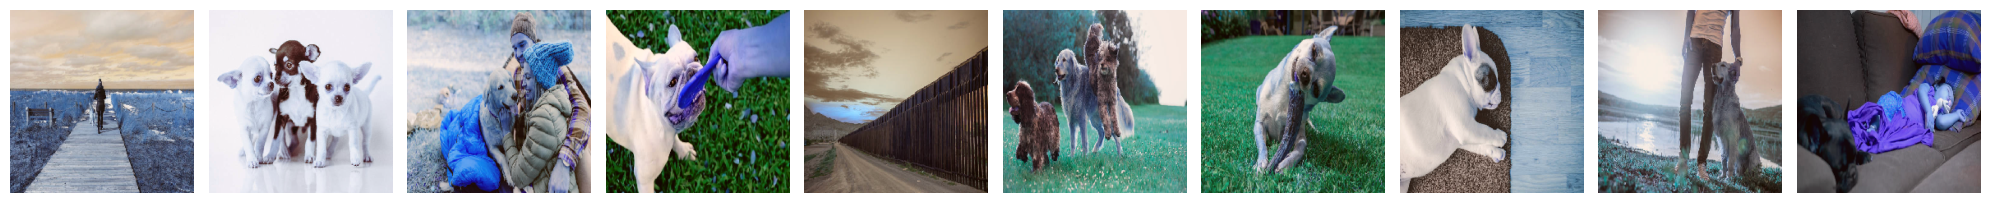

[[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [ ]:
plotImages(imgs_resnet50)
print(labels_resnet50)

<h2>Training Model: ResNet50</h2>

In [ ]:
# ResNet50 Model
resnet50_model = ResNet50(weights=None, input_shape=(224,224,3), classes=len(train_batches_resnet50.class_indices))

In [ ]:
resnet50_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 23,544,837 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
start_time_resnet50 = time.time()

In [ ]:
history_resnet50 = resnet50_model.fit(x=train_batches_resnet50, validation_data=valid_batches_resnet50, epochs=50, verbose=2)
training_time_resnet50 = time.time() - start_time_resnet50

/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2025-01-21 20:54:27.216618: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-21 20:54:27.962805: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActi

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_215197/3713759711.py", line 1, in <module>

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/hakiminaim/tensorflow_env/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 2676869376 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_141873]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

resnet50_model.save('/content/drive/MyDrive/resnet50_model.h5')
print("ResNet50 model saved to Google Drive!")

Mounted at /content/drive
ResNet50 model saved to Google Drive!


In [ ]:
resnet50_model.save('/content/drive/MyDrive/resnet50_model.keras')
print("ResNet50 model saved to Google Drive in Keras format!")

ResNet50 model saved to Google Drive in Keras format!


<h2>Model Accuracy: ResNet50 </h2>

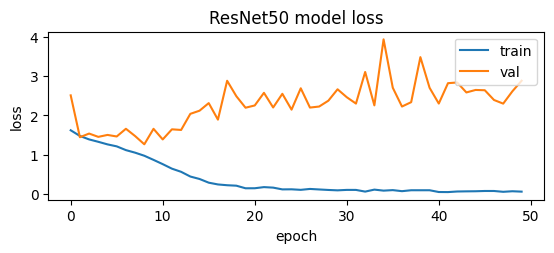

In [ ]:
plt.subplot(2,1,2)
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

<h2>Training Loss: ResNet50</h2>

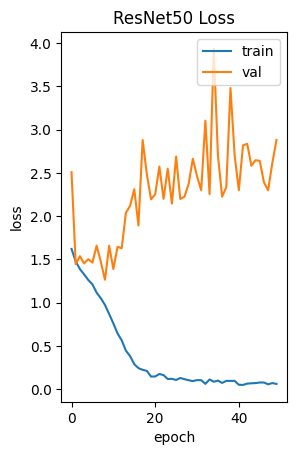

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['loss'], label='Train')
plt.plot(history_resnet50.history['val_loss'], label='Validation')
plt.title('ResNet50 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

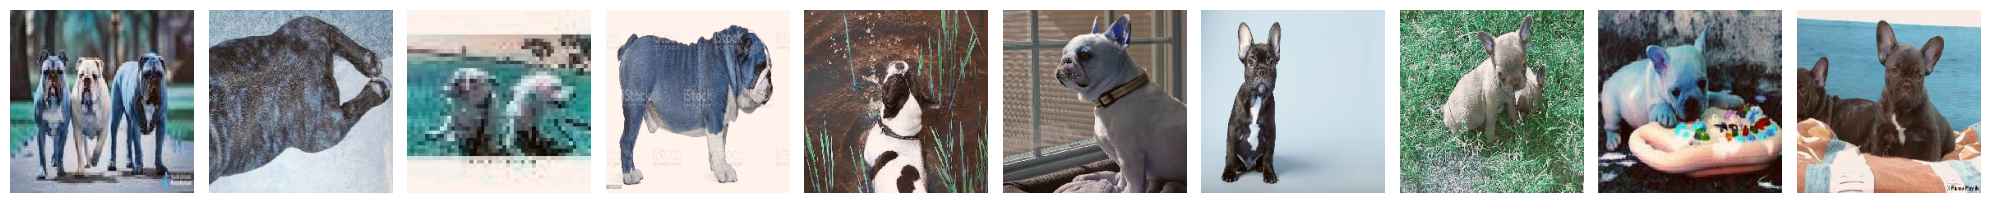

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [ ]:
test_imgs_resnet50, test_labels_resnet50 = next(test_batches_resnet50)
plotImages(test_imgs_resnet50)
print(test_labels_resnet50)

In [ ]:
test_batches_resnet50.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
predictions_resnet50 = resnet50_model.predict(x=test_batches_resnet50, verbose=0)

In [ ]:
np.round(predictions_resnet50)

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
cm_resnet50 = confusion_matrix(y_true=test_batches_resnet50.classes, y_pred=np.argmax(predictions_resnet50, axis=-1))

In [ ]:
test_batches_resnet50.class_indices

{'bull-dog': 0,
 'chihuahua': 1,
 'german-shepherd': 2,
 'golden-retriever': 3,
 'husky': 4}

Confusion matrix, without normalization
[[144   7  19  24   6]
 [ 83  43  22  38  14]
 [ 49  10 111  23   7]
 [ 41   4   8 142   5]
 [ 55  21  15  21  88]]


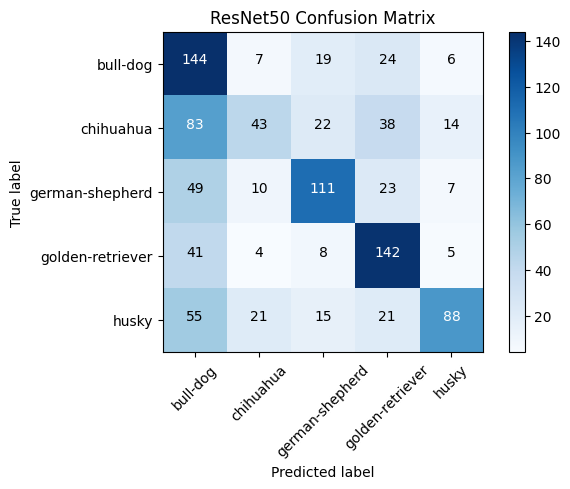

In [ ]:
cm_plot_labels_resnet50 = ['bull-dog', 'chihuahua', 'german-shepherd', 'golden-retriever', 'husky']
plot_confusion_matrix(cm=cm_resnet50, classes=cm_plot_labels_resnet50, title='ResNet50 Confusion Matrix')

In [ ]:
loss_resnet50, acc_resnet50 = resnet50_model.evaluate(test_imgs_resnet50, test_labels_resnet50, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7812 - loss: 1.0678


In [ ]:
print("Training time using ResNet50 model: " + str(training_time_resnet50 / 60) + " minute")

Training time using ResNet50 model: 64.67252555688222 minute


<h1>DenseNet121</h1>

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

train_batches_densenet121 = ImageDataGenerator(preprocessing_function=densenet_preprocess)\
    .flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        classes=['bull-dog', 'chihuahua', 'german-shepherd', 'golden-retriever', 'husky'],
        batch_size=32
    )

valid_batches_densenet121 = ImageDataGenerator(preprocessing_function=densenet_preprocess)\
    .flow_from_directory(
        directory=valid_path,
        target_size=(224, 224),
        classes=['bull-dog', 'chihuahua', 'german-shepherd', 'golden-retriever', 'husky'],
        batch_size=32
    )

test_batches_densenet121 = ImageDataGenerator(preprocessing_function=densenet_preprocess)\
    .flow_from_directory(
        directory=test_path,
        target_size=(224, 224),
        classes=['bull-dog', 'chihuahua', 'german-shepherd', 'golden-retriever', 'husky'],
        batch_size=32,
        shuffle=False
    )

Found 7000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [ ]:
assert train_batches_densenet121.n == 7000
assert valid_batches_densenet121.n == 2000
assert test_batches_densenet121.n == 1000
assert train_batches_densenet121.num_classes == valid_batches_densenet121.num_classes == test_batches_densenet121.num_classes == 5


In [ ]:
imgs_densenet121 , labels_densenet121 = next(train_batches_densenet121)

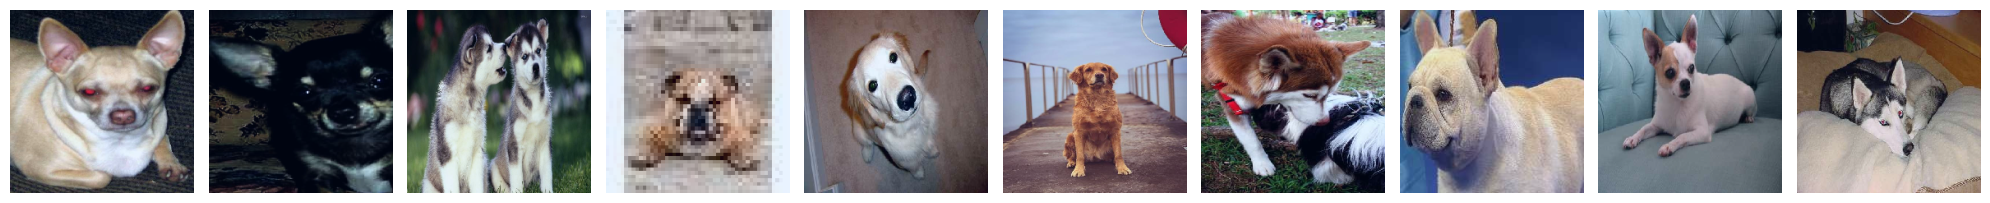

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [ ]:
plotImages(imgs_densenet121)
print(labels_densenet121)

<h2>Training Model: DenseNet121</h2>

In [ ]:
# DenseNet121 Model
densenet121_model = DenseNet121(weights=None, input_shape=(224,224,3), classes=len(train_batches_densenet121.class_indices))

In [ ]:
densenet121_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,042,629 (26.87 MB)

 Trainable params: 6,958,981 (26.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
densenet121_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
start_time_densenet121 = time.time()

In [ ]:
history_densenet121 = densenet121_model.fit(x=train_batches_densenet121, validation_data=valid_batches_densenet121, epochs=50, verbose=2)
training_time_densenet121 = time.time() - start_time_densenet121

Epoch 1/50
219/219 - 377s - 2s/step - accuracy: 0.4006 - loss: 1.4278 - val_accuracy: 0.3800 - val_loss: 1.6618
Epoch 2/50
219/219 - 90s - 413ms/step - accuracy: 0.5043 - loss: 1.2420 - val_accuracy: 0.4515 - val_loss: 1.4819
Epoch 3/50
219/219 - 73s - 335ms/step - accuracy: 0.5714 - loss: 1.0870 - val_accuracy: 0.5685 - val_loss: 1.0933
Epoch 4/50
219/219 - 82s - 375ms/step - accuracy: 0.6283 - loss: 0.9702 - val_accuracy: 0.6090 - val_loss: 1.0472
Epoch 5/50
219/219 - 74s - 338ms/step - accuracy: 0.6781 - loss: 0.8464 - val_accuracy: 0.5585 - val_loss: 1.2157
Epoch 6/50
219/219 - 82s - 373ms/step - accuracy: 0.7214 - loss: 0.7411 - val_accuracy: 0.4860 - val_loss: 1.5636
Epoch 7/50
219/219 - 82s - 373ms/step - accuracy: 0.7684 - loss: 0.6223 - val_accuracy: 0.5655 - val_loss: 1.2162
Epoch 8/50
219/219 - 74s - 338ms/step - accuracy: 0.8127 - loss: 0.5184 - val_accuracy: 0.6585 - val_loss: 0.9585
Epoch 9/50
219/219 - 82s - 373ms/step - accuracy: 0.8557 - loss: 0.4109 - val_accuracy: 0.

In [ ]:
# Or save it to Google Drive
densenet121_model.save('/content/drive/MyDrive/densenet121_model.h5')
print("DenseNet121 model saved to Google Drive!")

densenet121_model.save('/content/drive/MyDrive/densenet121_model.keras')
print("DenseNet121 model saved to Google Drive in Keras format!")

DenseNet121 model saved to Google Drive!
DenseNet121 model saved to Google Drive in Keras format!


<h2>Model Accuracy: DenseNet121</h2>

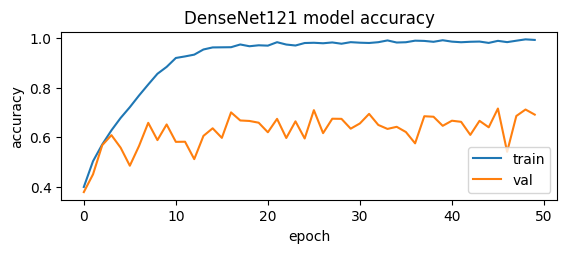

In [ ]:
plt.subplot(2,1,1)
plt.plot(history_densenet121.history['accuracy'])
plt.plot(history_densenet121.history['val_accuracy'])
plt.title('DenseNet121 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

<h2>Training Loss: DenseNet121</h2>

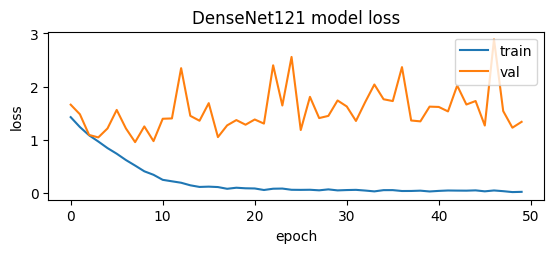

In [ ]:
plt.subplot(2,1,2)
plt.plot(history_densenet121.history['loss'])
plt.plot(history_densenet121.history['val_loss'])
plt.title('DenseNet121 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

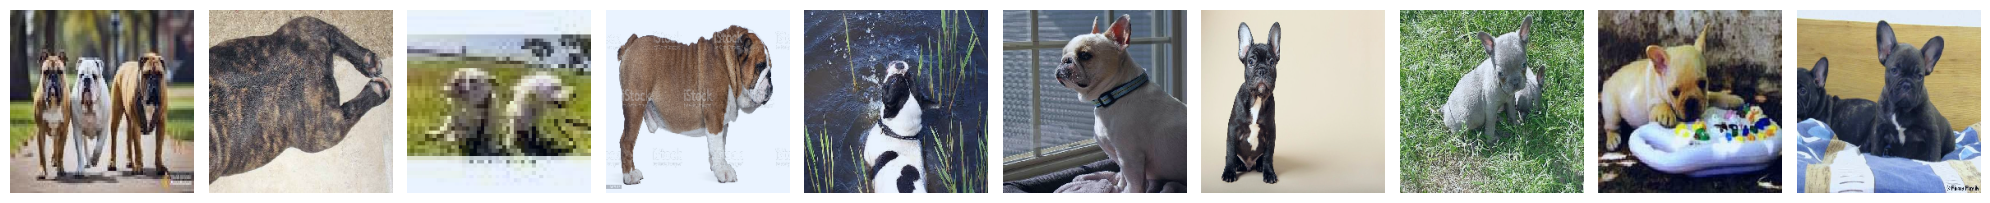

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [ ]:
test_imgs_densenet121, test_labels_densenet121 = next(test_batches_densenet121)
plotImages(test_imgs_densenet121)
print(test_labels_densenet121)

In [ ]:
test_batches_densenet121.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
predictions_densenet121 = densenet121_model.predict(x=test_batches_densenet121, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [ ]:
np.round(predictions_densenet121)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
cm_densenet121 = confusion_matrix(y_true=test_batches_densenet121.classes, y_pred=np.argmax(predictions_densenet121, axis=-1))

In [ ]:
test_batches_densenet121.class_indices

{'bull-dog': 0,
 'chihuahua': 1,
 'german-shepherd': 2,
 'golden-retriever': 3,
 'husky': 4}

Confusion matrix, without normalization
[[139  19  13  26   3]
 [ 39 100  10  33  18]
 [ 16  11 144  21   8]
 [  5   8   5 181   1]
 [ 25  17   6  26 126]]


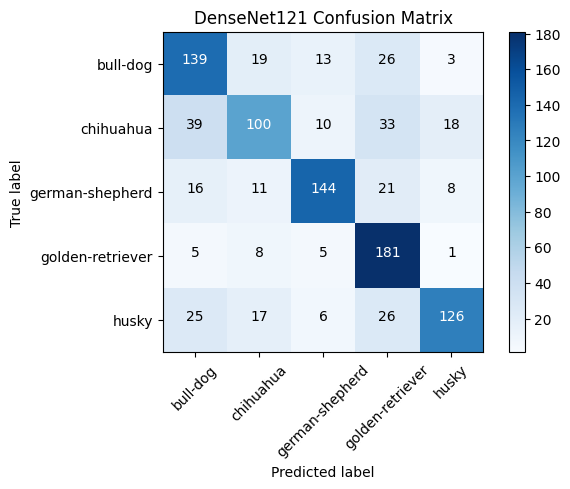

In [ ]:
cm_plot_labels_densenet121 = ['bull-dog', 'chihuahua', 'german-shepherd', 'golden-retriever', 'husky']
plot_confusion_matrix(cm=cm_densenet121, classes=cm_plot_labels_densenet121, title='DenseNet121 Confusion Matrix')

In [ ]:
loss_densenet121, acc_densenet121 = densenet121_model.evaluate(test_imgs_densenet121, test_labels_densenet121, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7188 - loss: 0.9578


In [ ]:
print("Training time using DenseNet121 model: " + str(training_time_densenet121 / 60) + " minute")

Training time using DenseNet121 model: 70.56030356486639 minute


<h1>MobileNetV3</h1>

In [ ]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess

train_batches_mobilenetv3 = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)\
    .flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        classes=['bull-dog', 'chihuahua', 'german-shepherd', 'golden-retriever', 'husky'],
        batch_size=32
    )

valid_batches_mobilenetv3 = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)\
    .flow_from_directory(
        directory=valid_path,
        target_size=(224, 224),
        classes=['bull-dog', 'chihuahua', 'german-shepherd', 'golden-retriever', 'husky'],
        batch_size=32
    )

test_batches_mobilenetv3 = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)\
    .flow_from_directory(
        directory=test_path,
        target_size=(224, 224),
        classes=['bull-dog', 'chihuahua', 'german-shepherd', 'golden-retriever', 'husky'],
        batch_size=32,
        shuffle=False
    )

Found 7000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [ ]:
assert train_batches_mobilenetv3.n == 7000
assert valid_batches_mobilenetv3.n == 2000
assert test_batches_mobilenetv3.n == 1000
assert train_batches_mobilenetv3.num_classes == valid_batches_mobilenetv3.num_classes == test_batches_mobilenetv3.num_classes == 5


In [ ]:
imgs_mobilenetv3 , labels_mobilenetv3 = next(train_batches_mobilenetv3)

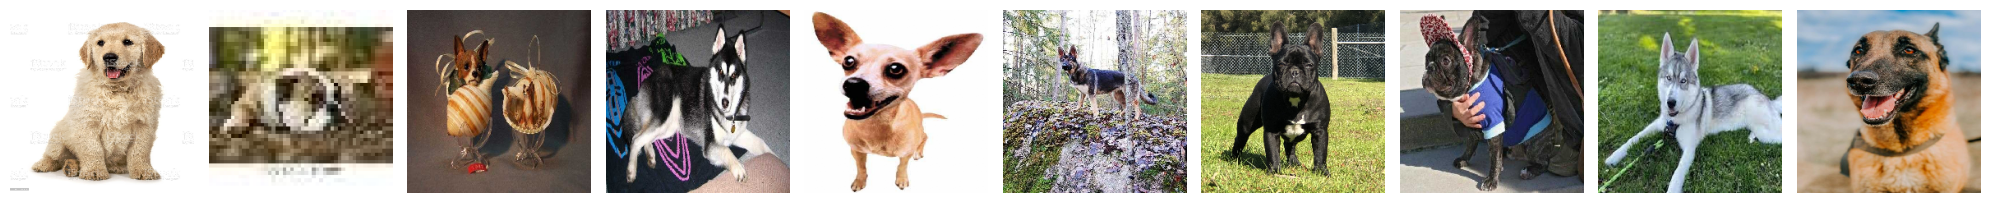

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [ ]:
plotImages(imgs_mobilenetv3)
print(labels_mobilenetv3)

<h2>Training Model: MobileNetV3</h2>

In [ ]:
# MobileNetV3 Model
mobilenetv3_model = MobileNetV3Small(weights=None, input_shape=(224,224,3), classes=len(train_batches_mobilenetv3.class_indices))

In [ ]:
mobilenetv3_model.summary()

Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 113, 113, 16)   │              0 │ activation[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 56, 56, 16)     │            144 │ expanded_conv_depthwi… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 56, 56, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 56, 56, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │              0 │ re_lu[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │            136 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │              0 │ expanded_conv_squeeze… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │            144 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 16)       │              0 │ expanded_conv_squeeze… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 1, 1, 16)       │              0 │ add[0][0]              │
├──────────────────────

 Total params: 1,535,093 (5.86 MB)

 Trainable params: 1,522,981 (5.81 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [ ]:
mobilenetv3_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
start_time_mobilenetv3 = time.time()

In [ ]:
history_mobilenetv3 = mobilenetv3_model.fit(x=train_batches_mobilenetv3, validation_data=valid_batches_mobilenetv3, epochs=50, verbose=2)
training_time_mobilenetv3 = time.time() - start_time_mobilenetv3

Epoch 1/50
219/219 - 190s - 867ms/step - accuracy: 0.2893 - loss: 1.5593 - val_accuracy: 0.2000 - val_loss: 1.6095
Epoch 2/50
219/219 - 70s - 318ms/step - accuracy: 0.3953 - loss: 1.4113 - val_accuracy: 0.2000 - val_loss: 1.6096
Epoch 3/50
219/219 - 45s - 206ms/step - accuracy: 0.5026 - loss: 1.2449 - val_accuracy: 0.2000 - val_loss: 1.6101
Epoch 4/50
219/219 - 38s - 173ms/step - accuracy: 0.5851 - loss: 1.0439 - val_accuracy: 0.2000 - val_loss: 1.6114
Epoch 5/50
219/219 - 31s - 143ms/step - accuracy: 0.6851 - loss: 0.8354 - val_accuracy: 0.2000 - val_loss: 1.6146
Epoch 6/50
219/219 - 36s - 163ms/step - accuracy: 0.7576 - loss: 0.6483 - val_accuracy: 0.2000 - val_loss: 1.6230
Epoch 7/50
219/219 - 32s - 146ms/step - accuracy: 0.8047 - loss: 0.5259 - val_accuracy: 0.2000 - val_loss: 1.6322
Epoch 8/50
219/219 - 40s - 182ms/step - accuracy: 0.8547 - loss: 0.3978 - val_accuracy: 0.2000 - val_loss: 1.6536
Epoch 9/50
219/219 - 45s - 206ms/step - accuracy: 0.8713 - loss: 0.3444 - val_accuracy:

In [ ]:
# Or save it to Google Drive
mobilenetv3_model.save('/content/drive/MyDrive/mobilenetv3_model.h5')
print("DenseNet121 model saved to Google Drive!")

mobilenetv3_model.save('/content/drive/MyDrive/mobilenetv3_model.keras')
print("MobileNetV3 model saved to Google Drive in Keras format!")

DenseNet121 model saved to Google Drive!
MobileNetV3 model saved to Google Drive in Keras format!


<h2>Model Accuracy: MobileNetV3</h2>

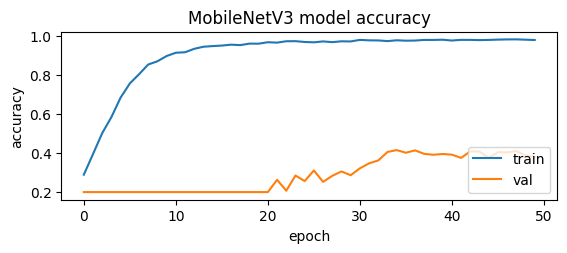

In [ ]:
plt.subplot(2,1,1)
plt.plot(history_mobilenetv3.history['accuracy'])
plt.plot(history_mobilenetv3.history['val_accuracy'])
plt.title('MobileNetV3 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

<h2>Training Loss: MobileNetV3</h2>

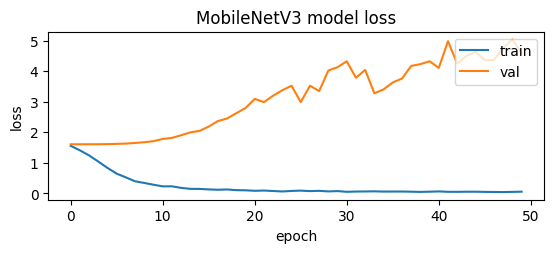

In [ ]:
plt.subplot(2,1,2)
plt.plot(history_mobilenetv3.history['loss'])
plt.plot(history_mobilenetv3.history['val_loss'])
plt.title('MobileNetV3 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

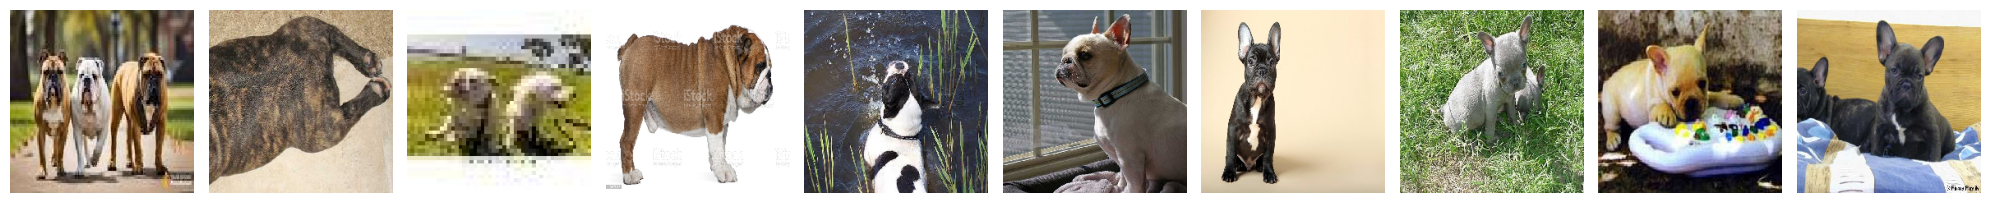

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [ ]:
test_imgs_mobilenetv3, test_labels_mobilenetv3 = next(test_batches_mobilenetv3)
plotImages(test_imgs_mobilenetv3)
print(test_labels_mobilenetv3)

In [ ]:
test_batches_mobilenetv3.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
predictions_mobilenetv3 = mobilenetv3_model.predict(x=test_batches_mobilenetv3, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [ ]:
np.round(predictions_mobilenetv3)


array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
cm_mobilenetv3 = confusion_matrix(y_true=test_batches_mobilenetv3.classes, y_pred=np.argmax(predictions_mobilenetv3, axis=-1))

In [ ]:
test_batches_mobilenetv3.class_indices

{'bull-dog': 0,
 'chihuahua': 1,
 'german-shepherd': 2,
 'golden-retriever': 3,
 'husky': 4}

Confusion matrix, without normalization
[[ 84  27  23  29  37]
 [ 54  48  19  47  32]
 [ 49  20  66  42  23]
 [ 31  25  20 110  14]
 [ 48  32  13  27  80]]


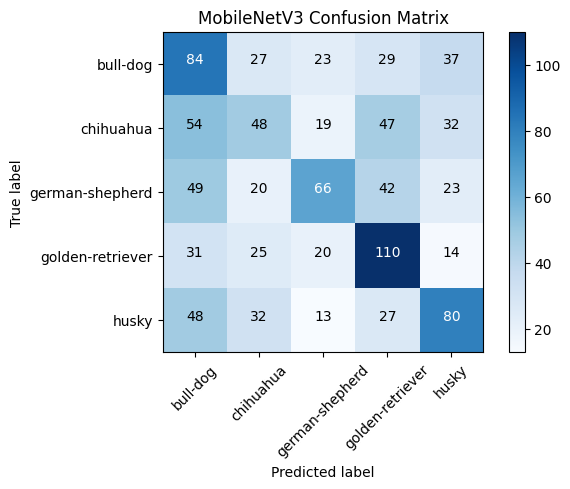

In [ ]:
cm_plot_labels_mobilenetv3 = ['bull-dog', 'chihuahua', 'german-shepherd', 'golden-retriever', 'husky']
plot_confusion_matrix(cm=cm_mobilenetv3, classes=cm_plot_labels_mobilenetv3, title='MobileNetV3 Confusion Matrix')

In [ ]:
loss_mobilenetv3, acc_mobilenetv3 = mobilenetv3_model.evaluate(test_imgs_mobilenetv3, test_labels_mobilenetv3, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4688 - loss: 3.8320


In [ ]:
print("Training time using MobileNetV3 model: " + str(training_time_mobilenetv3/60) + "minutes")

Training time using MobileNetV3 model: 32.353777762254076minutes
